In [86]:
%reset -f

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [88]:
advanced_df = pd.read_csv("dataset_mood_smartphone (1).csv", index_col=0)

In [89]:
advanced_df.head()

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


## Define functions

In [90]:
# Check the shape of a dataframe, along with NaN values
def check_df(df):
    print(df.shape)
    for item in df.columns:
        print(item, ': ', type(df[item]), ', contains NaN:',df[item].isnull().values.any())

# Plot all the variables vs time
def plot_feature(df, variable_name, participant=None):
    ylabel_text = f"{variable_name} value"
    title_text = f"{variable_name} vs time"

    if participant:
        plot = df[(df['variable'] == variable_name) & (df['id'] == participant)]
    else:
        plot = df[(df['variable'] == variable_name)]

    plt.plot(plot['time'], plot['value'], label = variable_name)
    plt.xlabel('time')
    plt.ylabel(ylabel_text)
    plt.title(title_text)
    plt.legend(loc='lower right')
    plt.show()

# Plot histograms of all the variables
def plot_histograms(df, variable_name, participant=None):

    if participant:
        df[(df['variable'] == variable_name) & (df['id'] == participant)].plot(kind='hist', bins=10, edgecolor='black', legend = variable_name)
    else:
        df[(df['variable'] == variable_name)].plot(kind='hist', bins=10, edgecolor='black', legend = variable_name)
    plt.xlabel(variable_name)
    plt.legend(loc='lower right')

# Remove outliers >0.75 and <0.25 of all values, excepting mood, call, sms etc
def remove_outliers(df, column_name, multiplier=1.5):
    q1 = df[column_name].quantile(0.10)
    q2 = df[column_name].quantile(0.95)
    iqr = q2 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q2 + multiplier * iqr
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# Check a dataframe for class balance
def check_class_balance(df, target_column):
    print(df[target_column].value_counts())

# Remove negative values
def filter_negative_values(row):
    variable = row['variable']
    value = row['value']

    if variable not in ['circumplex.arousal', 'circumplex.valence'] and value < 0:
        return False
    return True

## Check for dataframe shape and NaN values

In [91]:
check_df(advanced_df)

(376912, 4)
id :  <class 'pandas.core.series.Series'> , contains NaN: False
time :  <class 'pandas.core.series.Series'> , contains NaN: False
variable :  <class 'pandas.core.series.Series'> , contains NaN: False
value :  <class 'pandas.core.series.Series'> , contains NaN: True


## Checking which variables have NaN values

In [92]:
advanced_df.query('value.isnull()')

,id,time,variable,value
5709,AS14.01,2014-04-02 18:00:00.000,circumplex.arousal,NaN
5731,AS14.01,2014-04-07 15:00:00.000,circumplex.arousal,NaN
5773,AS14.01,2014-04-16 12:00:00.000,circumplex.arousal,NaN
5797,AS14.01,2014-04-21 13:00:00.000,circumplex.arousal,NaN
5836,AS14.01,2014-04-29 09:00:00.000,circumplex.arousal,NaN
...,...,...,...,...
16859,AS14.33,2014-05-16 20:00:00.000,circumplex.valence,NaN
16862,AS14.33,2014-05-17 12:00:00.000,circumplex.valence,NaN
16882,AS14.33,2014-05-21 16:00:00.000,circumplex.valence,NaN
16899,AS14.33,2014-05-24 23:00:00.000,circumplex.valence,NaN


In [93]:
print('circumplex.arousal NaNs count: ', advanced_df[advanced_df['variable']=='circumplex.arousal'].isna().sum())
print('circumplex.valence NaNs count: ', advanced_df[advanced_df['variable']=='circumplex.valence'].isna().sum())

circumplex.arousal NaNs count:  id           0
time         0
variable     0
value       46
dtype: int64
circumplex.valence NaNs count:  id            0
time          0
variable      0
value       156
dtype: int64


In [94]:
print(advanced_df['variable'].value_counts())

screen                  96578
appCat.builtin          91288
appCat.communication    74276
appCat.entertainment    27125
activity                22965
appCat.social           19145
appCat.other             7650
circumplex.valence       5643
circumplex.arousal       5643
appCat.office            5642
mood                     5641
call                     5239
appCat.travel            2846
appCat.utilities         2487
sms                      1798
appCat.finance            939
appCat.unknown            939
appCat.game               813
appCat.weather            255
Name: variable, dtype: int64


In [95]:
grouped_data = advanced_df.groupby('variable')

# Calculate the min and max for each group
min_values = grouped_data['value'].min()
max_values = grouped_data['value'].max()

# Calculate the range for each group
range_values = max_values - min_values

# Combine the min, max, and range values into a single DataFrame
ranges = pd.concat([min_values, max_values, range_values], axis=1)
ranges.columns = ['min_value', 'max_value', 'range']

# Print the range for each unique feature in the 'variable' column
print("Range of values for each unique feature in the 'variable' column:")
print(ranges)

Range of values for each unique feature in the 'variable' column:
                      min_value  max_value       range
variable                                              
activity                  0.000      1.000       1.000
appCat.builtin       -82798.871  33960.246  116759.117
appCat.communication      0.006   9830.777    9830.771
appCat.entertainment     -0.011  32148.677   32148.688
appCat.finance            0.131    355.513     355.382
appCat.game               1.003   5491.793    5490.790
appCat.office             0.003  32708.818   32708.815
appCat.other              0.014   3892.038    3892.024
appCat.social             0.094  30000.906   30000.812
appCat.travel             0.080  10452.615   10452.535
appCat.unknown            0.111   2239.937    2239.826
appCat.utilities          0.246   1802.649    1802.403
appCat.weather            1.003    344.863     343.860
call                      1.000      1.000       0.000
circumplex.arousal       -2.000      2.000       4.000

### The only variables that contain NaN values are circumplex.arousal and circumplex.valence. Discussion needs to be made if these values should be removed or be converted to 0s

## Drop rows with NaN values

In [96]:
advanced_df.dropna(inplace=True)
check_df(advanced_df)

(376710, 4)
id :  <class 'pandas.core.series.Series'> , contains NaN: False
time :  <class 'pandas.core.series.Series'> , contains NaN: False
variable :  <class 'pandas.core.series.Series'> , contains NaN: False
value :  <class 'pandas.core.series.Series'> , contains NaN: False


In [97]:
advanced_df = advanced_df[advanced_df.apply(filter_negative_values, axis=1)]

## Sort dataframe by id and time

In [98]:
advanced_df.sort_values(['id', 'time'], inplace=True)

C:\Users\nikos\AppData\Local\Temp\ipykernel_2716\1955268030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advanced_df.sort_values(['id', 'time'], inplace=True)


## Plot all features vs time for participant AS14.01

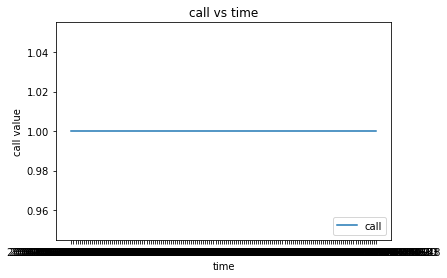

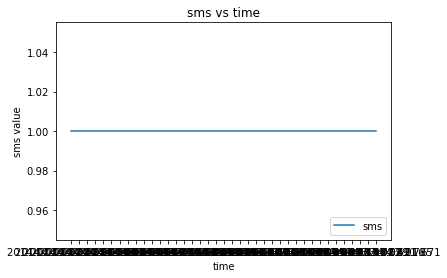

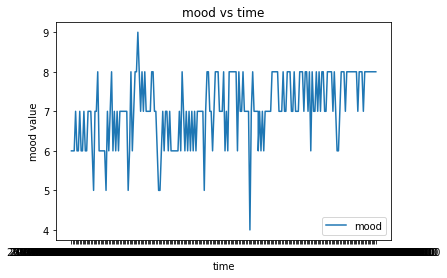

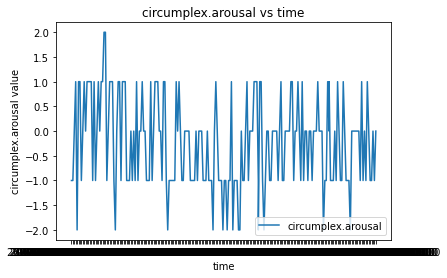

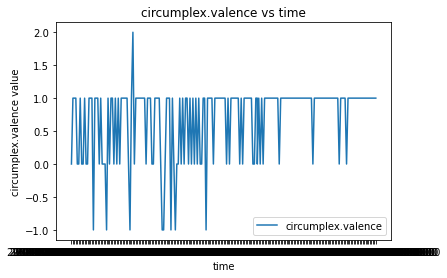

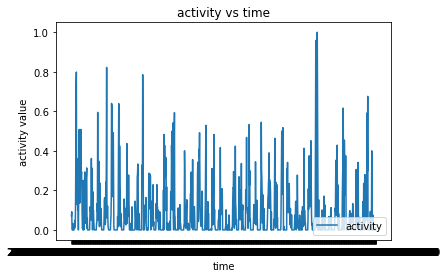

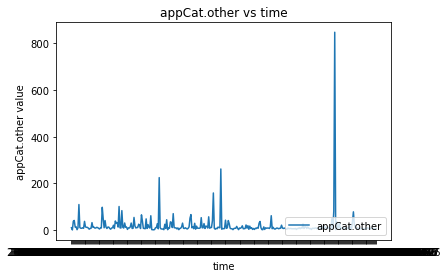

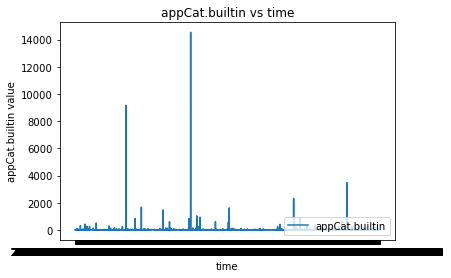

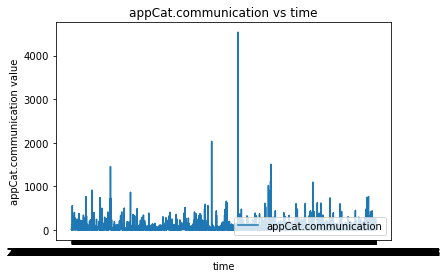

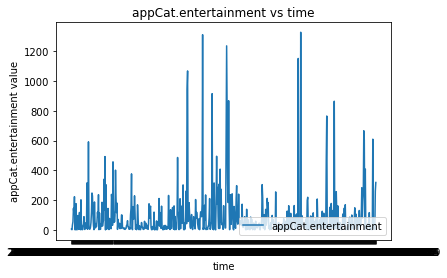

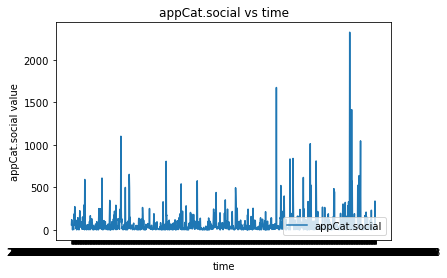

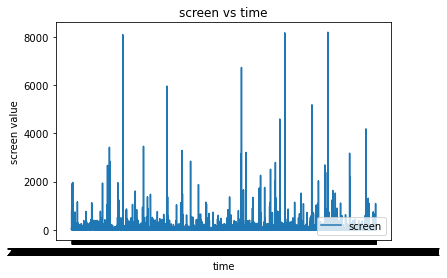

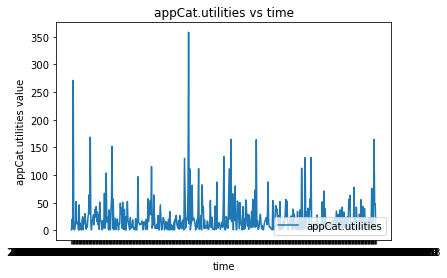

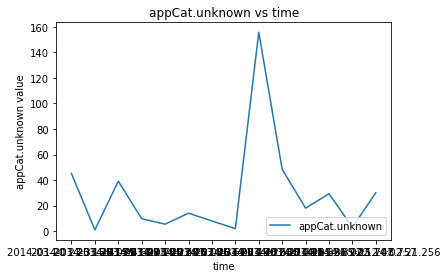

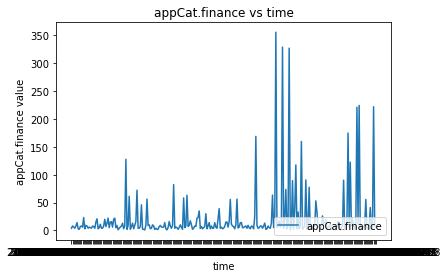

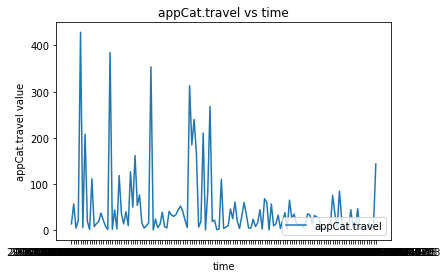

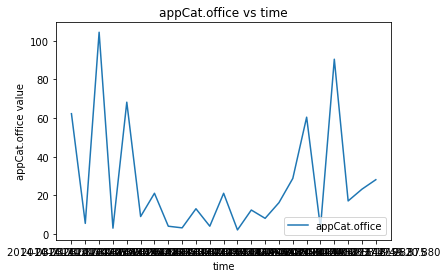

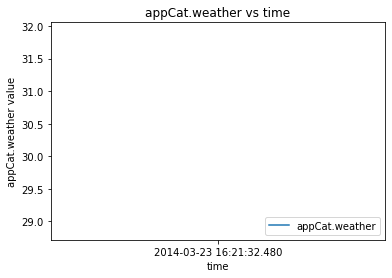

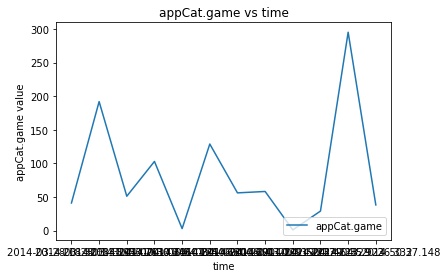

In [99]:
for name in advanced_df['variable'].unique():
    plot_feature(advanced_df, name, 'AS14.01')

## Plot variable values to check for distribution for participant AS14.01

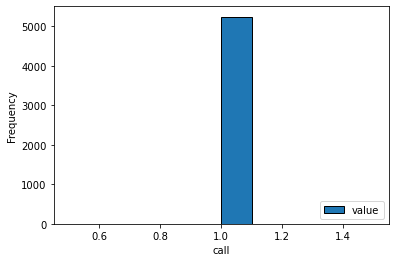

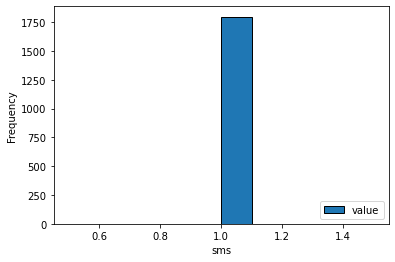

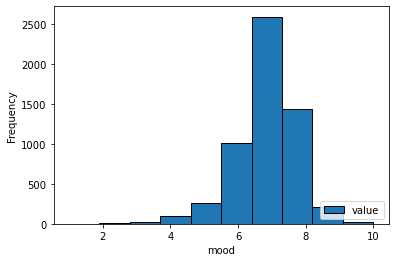

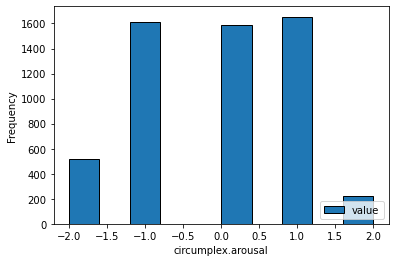

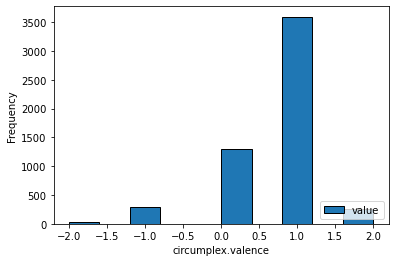

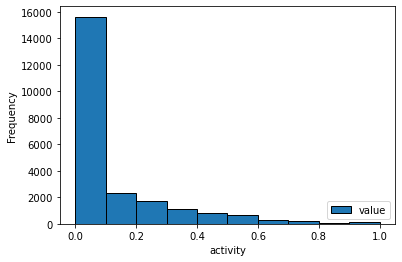

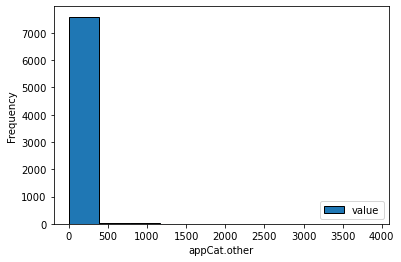

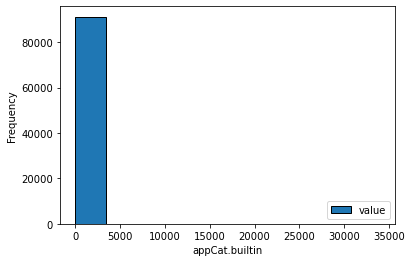

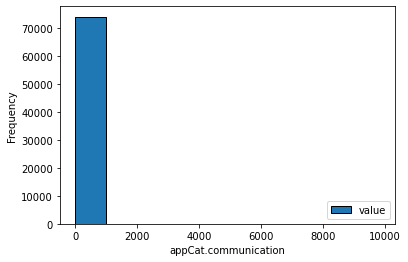

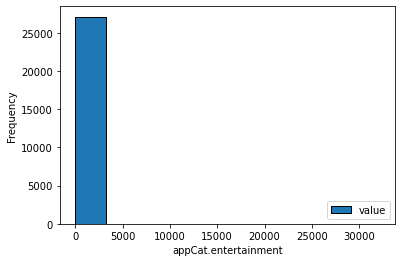

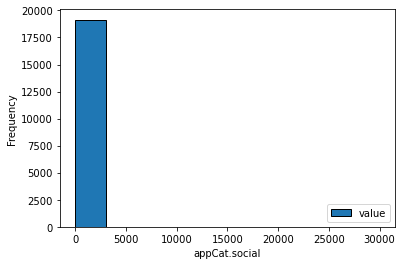

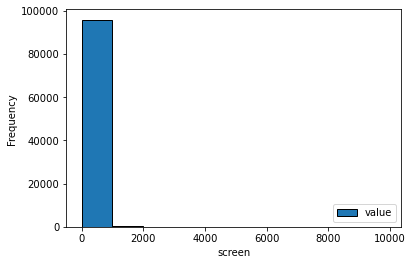

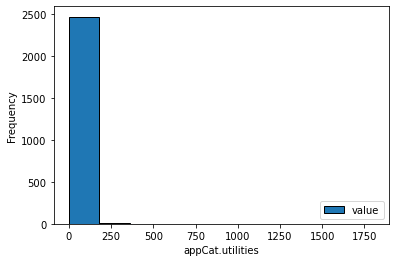

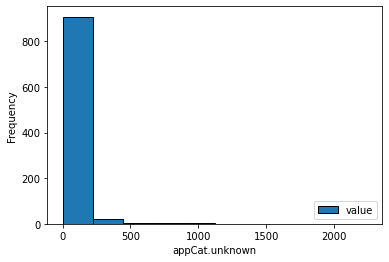

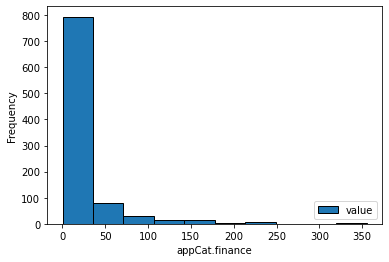

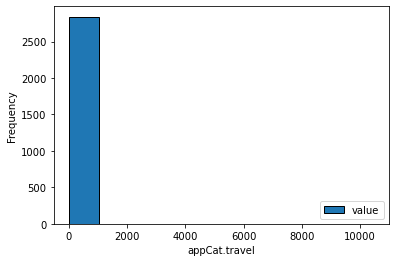

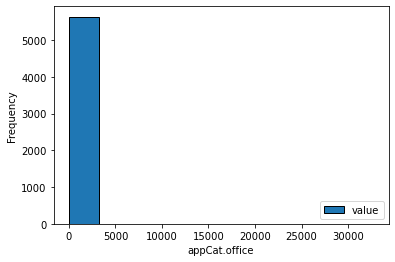

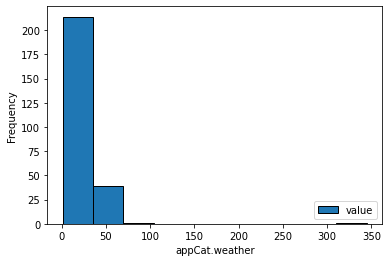

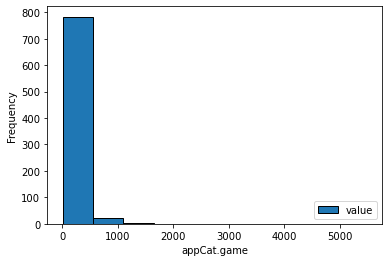

In [100]:
for name in advanced_df['variable'].unique():
    plot_histograms(advanced_df, name)

## Calculate mean and sd for each variable

In [101]:
result = advanced_df.groupby('variable')['value'].agg(['mean', 'std'])

## Remove outliers for all participants

In [102]:
filtered_data = []
exception_list = ['mood', 'sms', 'call', 'circumplex.arousal', 'circumplex.valence', 'activity']

for name in advanced_df['variable'].unique():
    if name in exception_list:
        filtered_data.append(advanced_df[advanced_df['variable'] == name])
        continue
    else:
        group = advanced_df[advanced_df['variable'] == name]
        filtered_group = remove_outliers(group, 'value')
        filtered_data.append(filtered_group)

clean_df = pd.concat(filtered_data)

## Check variable vs time after outliers removed

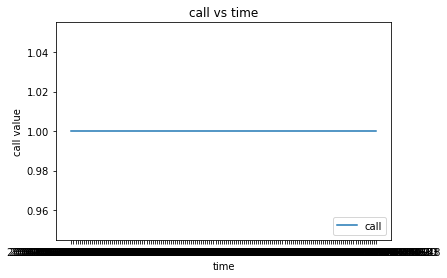

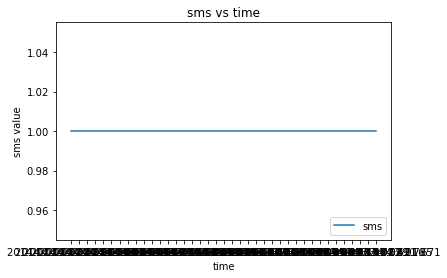

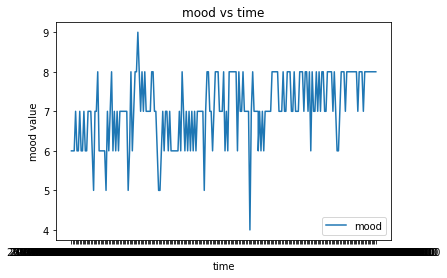

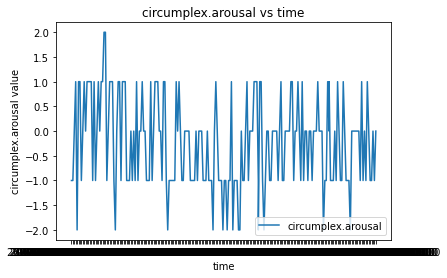

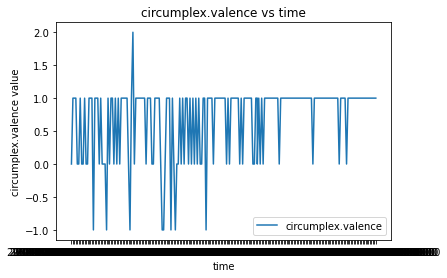

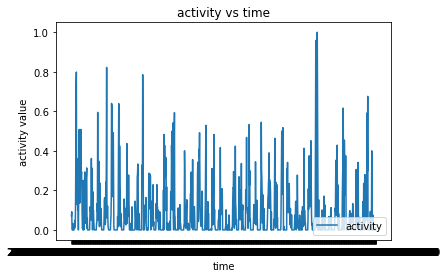

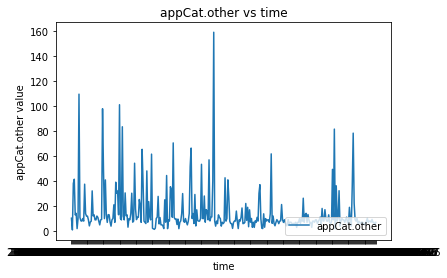

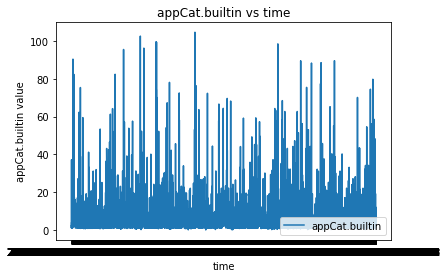

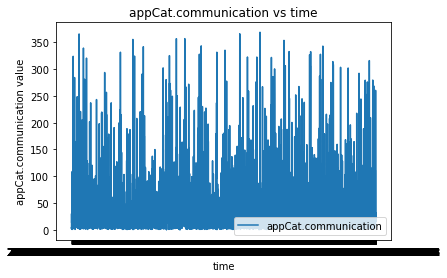

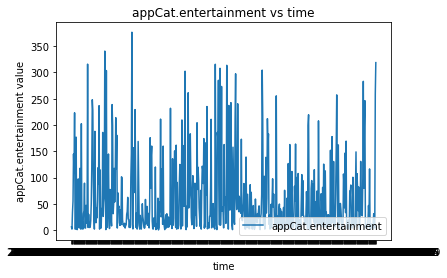

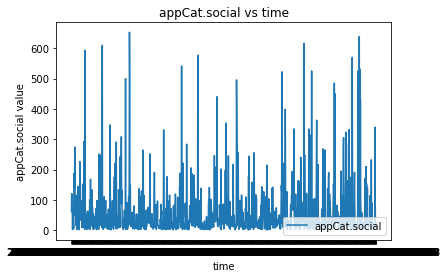

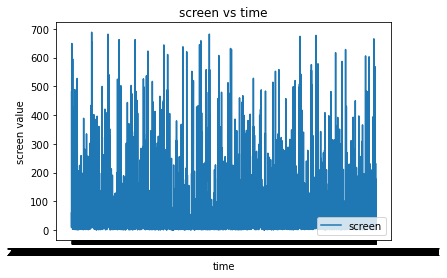

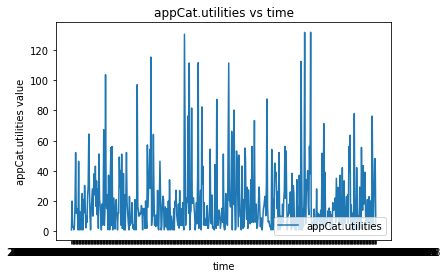

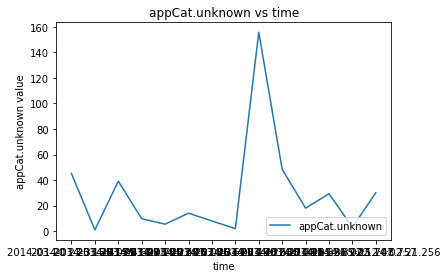

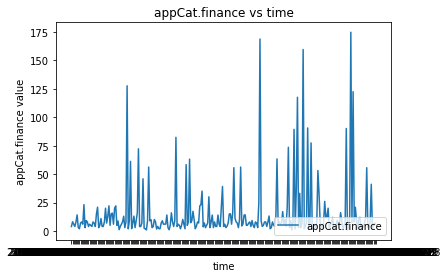

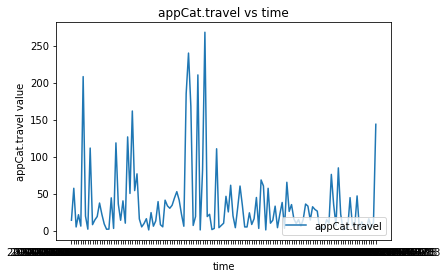

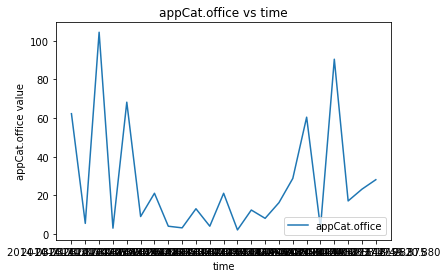

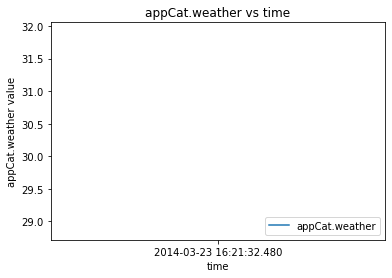

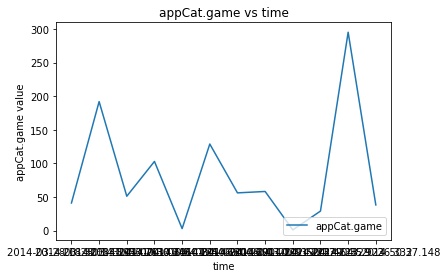

In [103]:
for name in clean_df['variable'].unique():
    plot_feature(clean_df, name, 'AS14.01')

## Check variable distribution for participant AS14.01 with the new data

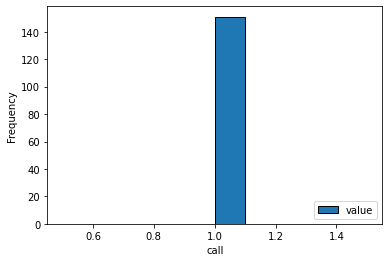

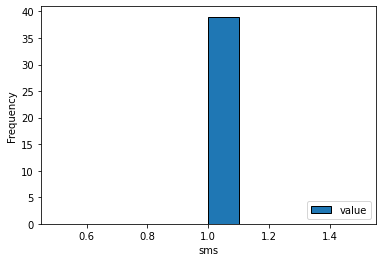

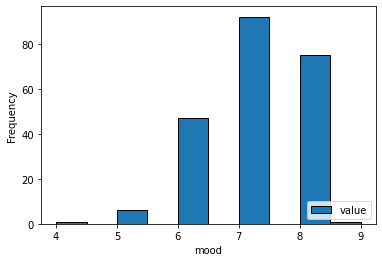

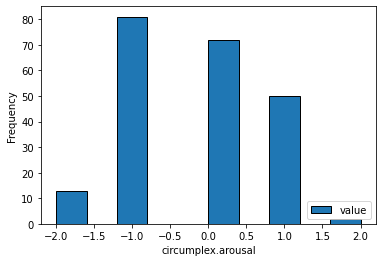

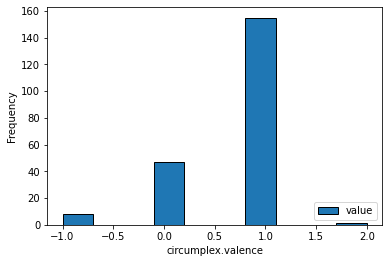

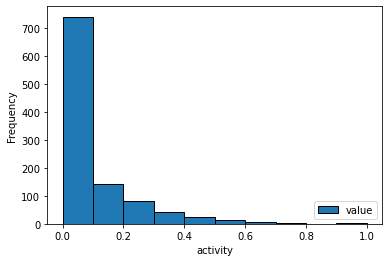

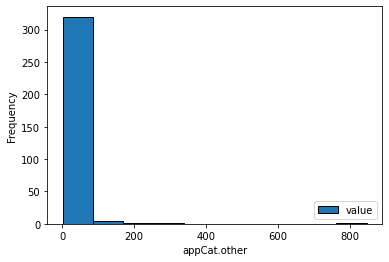

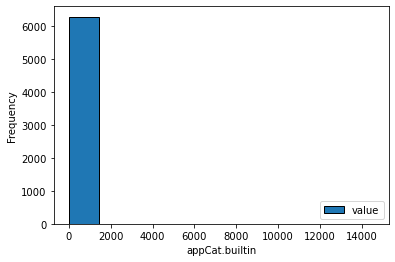

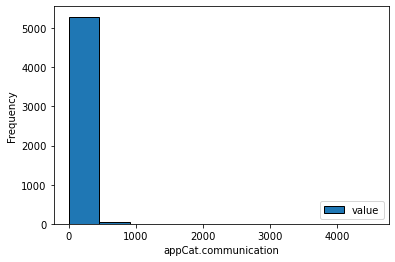

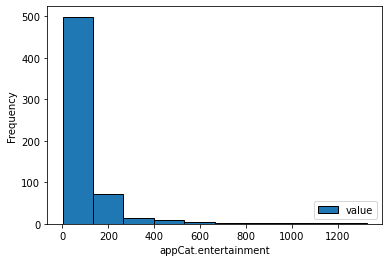

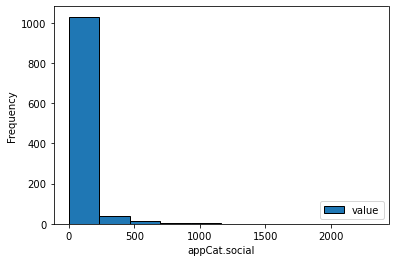

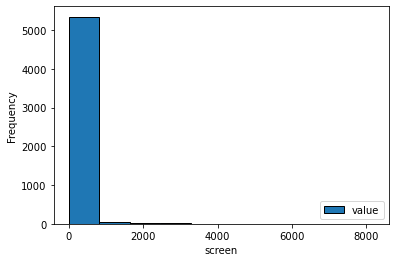

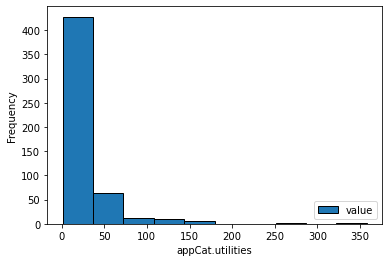

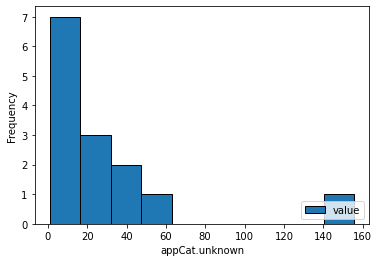

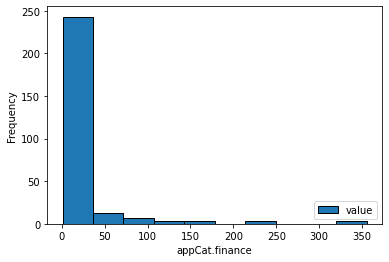

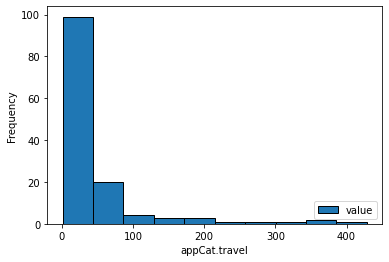

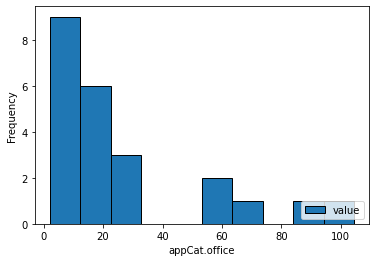

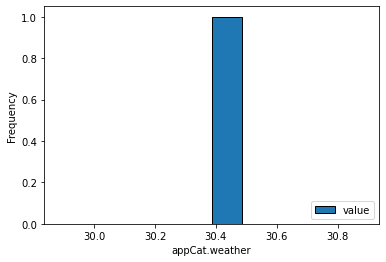

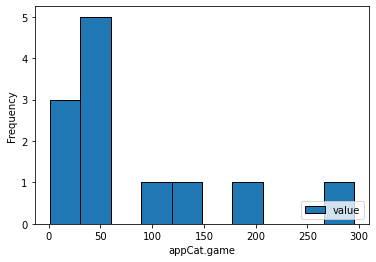

In [104]:
for name in advanced_df['variable'].unique():
    plot_histograms(advanced_df, name, 'AS14.01')

# Data engineering

## For each variable, calculate the average value if the variable is continuous and the count if the value is categorical, for each day, and distinguish the variable column to different features.

In [105]:
# Convert timestamp to datetime object and extract date
clean_df['time'] = pd.to_datetime(clean_df['time']).dt.date

# List of continuous and categorical variables
continuous_vars = ['mood', 'screen', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'circumplex.arousal', 'circumplex.valence', 'activity']
categorical_vars = ['call', 'sms']

# Define aggregation functions for continuous and categorical variables
aggregations = {}
for var in continuous_vars:
    aggregations[var] = 'mean'
for var in categorical_vars:
    aggregations[var] = 'count'

In [106]:
# Filter the dataframe for continuous and categorical variables
cont_df = clean_df[clean_df['variable'].isin(continuous_vars)].pivot_table(index=['id', 'time'], columns='variable', values='value').reset_index()
cat_df = clean_df[clean_df['variable'].isin(categorical_vars)].pivot_table(index=['id', 'time'], columns='variable', values='value', aggfunc='count').reset_index()

# Merge the dataframes
result = pd.merge(cont_df, cat_df, on=['id', 'time'], how='outer')

## Impute missing values

In [107]:
# Create an empty DataFrame with the same columns as the original
imputed_data = pd.DataFrame(columns=result.columns)

# Iterate through unique participant ids
for participant in result['id'].unique():
    participant_data = result[result['id'] == participant]

    # Calculate the mean of each column for the participant, excluding the 'id' column
    participant_mean = participant_data.drop(columns=['id']).mean()

    # Fill missing values with the participant-specific mean for each column
    participant_imputed = participant_data.copy()
    for column in participant_mean.index:
        participant_imputed[column] = participant_data[column].fillna(participant_mean[column])

    # Append the imputed participant data to the imputed_data DataFrame
    imputed_data = imputed_data.append(participant_imputed, ignore_index=True)

C:\Users\nikos\AppData\Local\Temp\ipykernel_2716\2974248145.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  participant_mean = participant_data.drop(columns=['id']).mean()
C:\Users\nikos\AppData\Local\Temp\ipykernel_2716\2974248145.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  imputed_data = imputed_data.append(participant_imputed, ignore_index=True)
C:\Users\nikos\AppData\Local\Temp\ipykernel_2716\2974248145.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  participant_mean = participant_data.drop(columns=['id']).mean()
C:\Users\nikos\AppData\Local\Te

In [108]:
imputed_data.replace(np.nan,0, inplace=True)

In [109]:
imputed_data.set_index('time', inplace=True)

# ML classifier

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Section for classic ML models

In [111]:
X = imputed_data.drop(columns=['mood'])
y = imputed_data['mood']
X.drop(['id'], axis = 1, inplace = True)

## Random forest classifier

In [112]:
rf_regressor = RandomForestRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [113]:
mae_scores = []
mse_scores = []
r2_scores = []

In [114]:
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf_regressor.fit(X_train, y_train)
    y_pred = rf_regressor.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

In [115]:
mean_mae = np.mean(mae_scores)
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)
print(f'Mean Absolute Error (MAE) across 5 folds: {mean_mae}')
print(f'Mean Squared Error (MSE) across 5 folds: {mean_mse}')
print(f'R-squared (R²) across 5 folds: {mean_r2}')

Mean Absolute Error (MAE) across 5 folds: 0.21628795425430275
Mean Squared Error (MSE) across 5 folds: 0.12327876188599374
R-squared (R²) across 5 folds: 0.6874371682922985
